# Clase2b: Introducción al uso de python para la manipulación de imágenes satelitales. 

Lo que veremos en esta notebook:

- [x] Lectura de una imagen satelital en formato geotiff
- [x] Extracción de los metadatos principales de una imagen satelital
- [x] Geotransformaciones
- [x] Lectura de matriz de datos
- [x] Visualización de una imagen satelital de una sola banda
- [x] Formato HDF

# 1. Imágenes satelitales
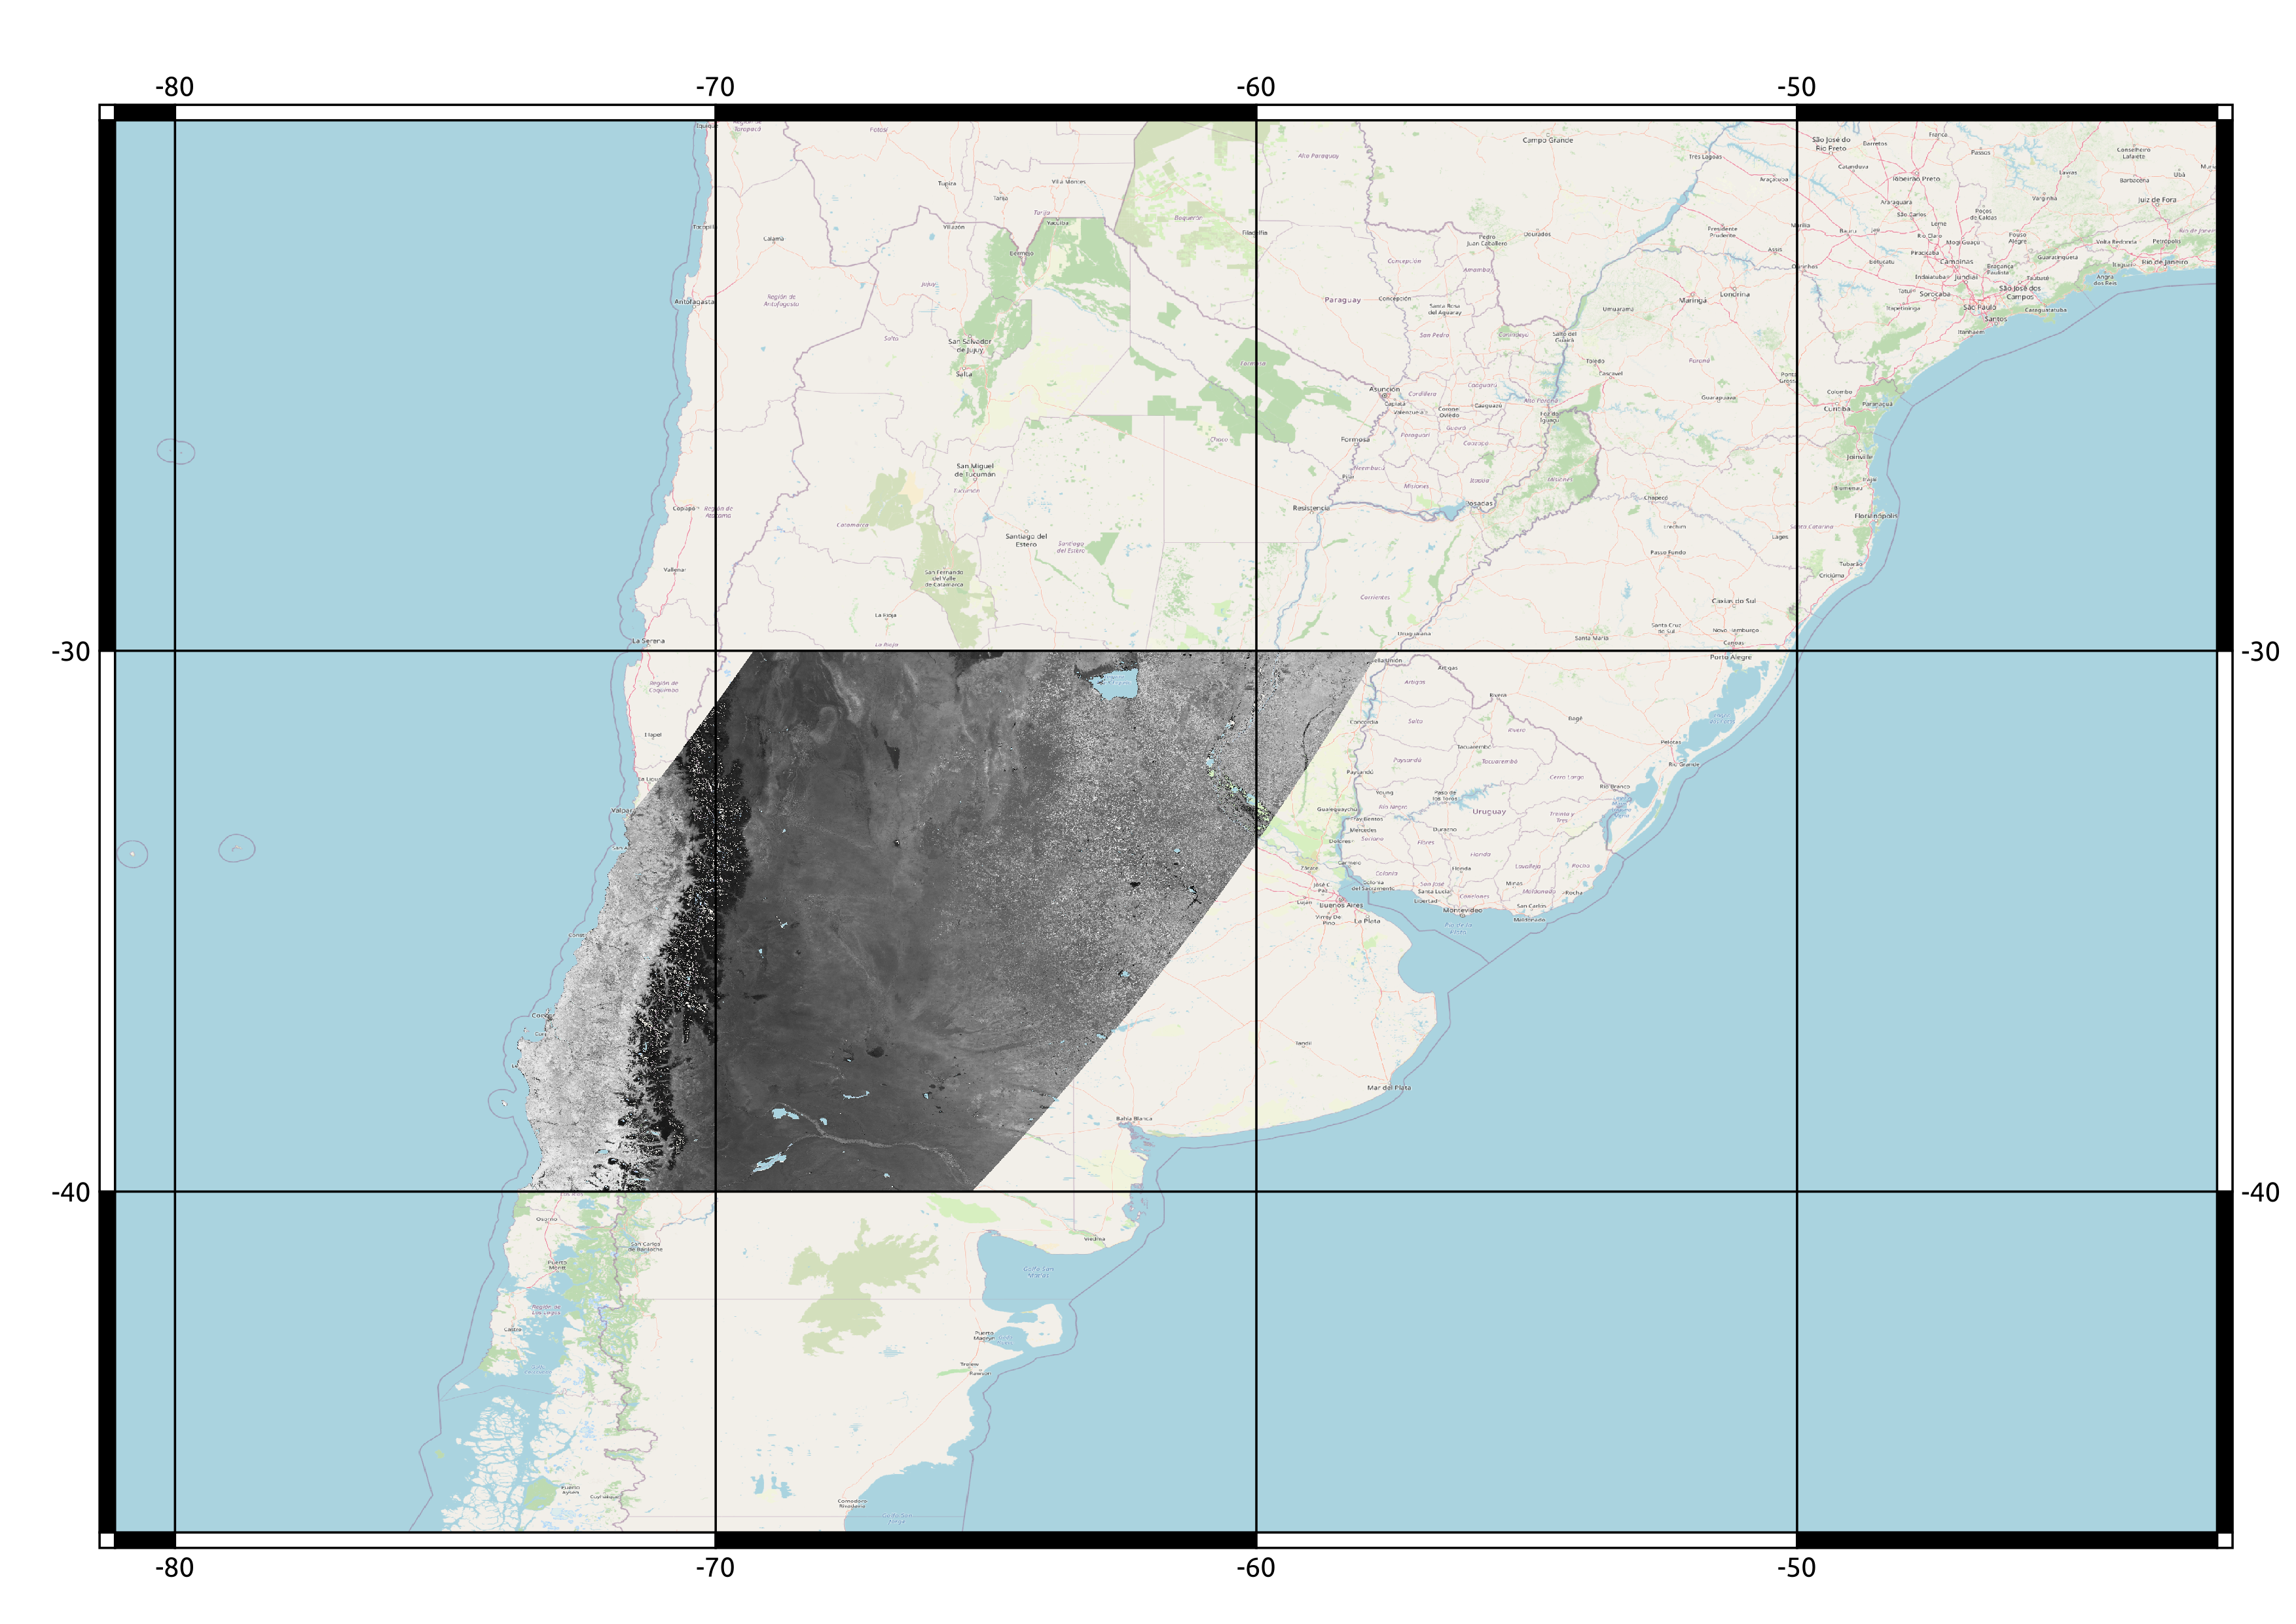

### ¿Qué información podremos extraer de una imagen satelital?
### ¿Cómo podemos acceder a dicha información?

# 2. Librería gdal
Es una librería utilizada para la lectura y procesamiento de datos geoespaciales de tipo ráster (gdal) y vectoriales (ogr). Es base para librerías de más alto nivel como rasterio. Existen 5 paquetes principales vinculados a gdal, los cuales, desde 2015 se importan de la siguiente manera: 

```python
from osgeo import gdal        # Manejo de datos Ráster
from osgeo import ogr         # Manejo de datos Vectoriales
from osgeo import osr         # Manejo de sistemas de referencia
from osgeo import gdal_array
from osgeo import gdalconst
```

Para información en detalle sobre la librería se puede consultar el siguiente [enlace](https://gdal.org/).


## 2.1. Información básica de un ráster

Comencemos por cargar las siguientes librerías:

```python
import matplotlib.pyplot as plt
from termcolor import colored
from osgeo import gdal
from osgeo import osr
import numpy as np
```

En la carpeta _raw_data_ tenemos una imagen llamada _SPOT_20170806_PAN.tif_. Haciendo uso de la función `gdal.Info()`, vamos a explorar parte de su estructura:

```python
print(gdal.Info('../data/raw_data/SPOT_20170806_PAN.tif', format='json'))
```

De la misma manera, `gdal` nos permite Vamos a cargar nuestra imagen como objeto y acceder a dicha estructura:

```python
ds = gdal.Open('../data/raw_data/SPOT_20170806_PAN.tif')
print(ds)

print(ds.GetMetadata())
```

Existen algunos comandos para acceder a la información básica de nuestros datos ráster también llamados _metadatos_. Estos proporcionan información acerca de las características de cada uno de nuestros recursos. Veamos como extraer información con la librería _gdal_: 

```python
print(ds.GetFileList())
print(ds.GetDescription())
```

```python
print(colored('Número de bandas:', 'blue'), ds.RasterCount)
print(colored('Número de columnas:', 'blue'), ds.RasterXSize)
print(colored('Número de filas:', 'blue'), ds.RasterYSize)
```

Podemos adicionalmente obtener datos acerca del sistema de referencia de la imagen, así como del formato de la misma:

```python
# Obtener información acerca del formato de la imagen
print(colored('Obtener el formato como objeto:\n', 'blue'), ds.GetDriver(), '\n')
print(colored('Nombre largo del formato:', 'blue'), ds.GetDriver().LongName, '\n')
print(colored('Abreviación del formato:', 'blue'), ds.GetDriver().ShortName)
```

Los drivers son necesarios cuando necesitamos guardar nuestras imágenes de salida. Estos se pueden traer desde la imagen original, como vimos anteriormente, así como crear a partir de su nombre abreviado, por ejemplo:

```python
new_driver = gdal.GetDriverByName('GTiff')
print(colored('Obtener el formato como objeto:\n', 'blue'), new_driver, '\n')
print(colored('Nombre largo del formato:', 'blue'), new_driver.LongName, '\n')
print(colored('Abreviación del formato:', 'blue'), new_driver.ShortName)
```

Más información acerca de los formatos disponibles la encontrarán en el siguiente [enlace](https://gdal.org/drivers/raster/index.html).

Otra información importante corresponde al sistema de referencia de coordenadas (SRC). Esto nos indica en qué proyección y qué unidades de mapa estamos trabajando. 

Cuando trabajamos con más de una imagen, deberíamos asegurarnos que estas se encuentren en el mismo sistema de referencia, así como el mísmo tamaño de píxel, garantizando la correspondencia entre los datos de la matríz.

```python
# Obtener proyección a partir de una imagen georreferenciada
# Información General
print(colored('Información acerca de la proyección de la capa:\n', 'blue'),
      ds.GetProjection(), '\n')

# Código EPSG
proj = osr.SpatialReference(wkt=ds.GetProjection())
print(colored('Código EPSG: ', 'blue'), proj.GetAttrValue("AUTHORITY", 1))
```

O de manera inversa, creamos nuestra proyección a partir de un EPSG conocido:
```python
# Crear proyección a partir de código EPSG
spatialRef = osr.SpatialReference()
spatialRef.ImportFromEPSG(32720)
print(spatialRef)
```

## 2.2. Geotransformaciones

Consiste en una tupla de 6 valores que contienen la información necesaria para realizar la transformación de matriz, a imagen georreferenciada en un mapa. Contiene los siguientes elementos:


>**GT(0)** = Coordenada x de la esquina superior izquierda del píxel superior izquierdo de la matriz\
**GT(1)** = Tamaño del píxel en sentido Oeste-Este\
**GT(2)** = Parámetro de rotación de las filas (Normalmente es cero)\
**GT(3)** = Coordenada y de la esquina superior izquierda del píxel superior izquierdo de la matriz\
**GT(4)** = Parámetro de rotación de las columnas (Normalmente es cero)\
**GT(5)** = Tamaño del píxel en sentido Norte-Sur (Este valor normalmente es negativo si el norte de la imagen coincide con la parte superior de la matriz)

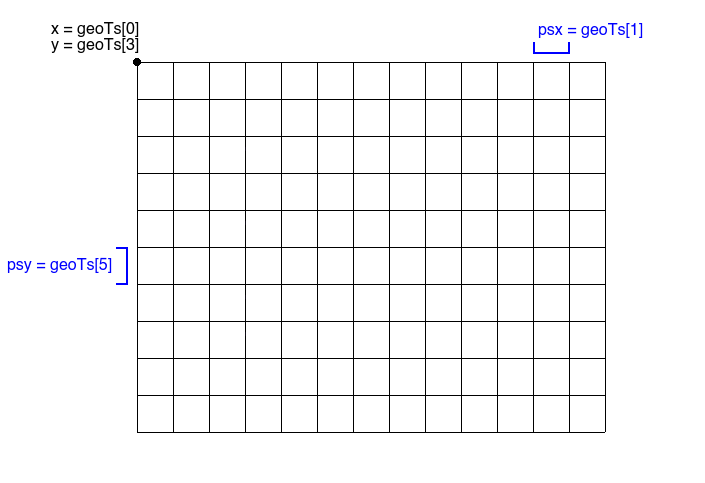

#### Cómo funciona?

X_geo = GT(0) + X_pixel * GT(1) + Y_line * GT(2)

Y_geo = GT(3) + X_pixel * GT(4) + Y_line * GT(5)

Para obtener más información acerca de las Geotransformaciones vaya al siguiente [enlace](https://gdal.org/tutorials/geotransforms_tut.html)

Los parámetros de Geotransformación de la imagen se obtienen de la siguiente manera:

```python
geoTs = ds.GetGeoTransform()
print(geoTs)
```

Veamos cómo obtener la coordenada central del píxel (200, 300) de la imagen cargada anteriormente a partir de sus geotransformaciones:

```python
p_x = 300
p_y = 200

ulx = geoTs[0]
uly = geoTs[3]

p_size_x = geoTs[1]
p_size_y = geoTs[5]

coord_x = ulx + p_x*p_size_x + 0  # geoTs[0] + p_x*geoTs[1] + p_y*geoTs[2]
coord_y = uly + 0 + p_y*p_size_y  # geoTs[3] + p_x*geoTs[4] + p_y*geoTs[5]

print(f'Coordenadas x, y, esquina superior izquierda del pixel ({p_y}, {p_x}):')
print(f'{coord_x:.3f}, {coord_y:.3f}')
print(f'Coordenadas x, y, centro del pixel ({p_y}, {p_x}):')
print(f'{coord_x + p_size_x/2:.3f}, {coord_y + p_size_y/2:.3f}')
```

## 2.3. El método ReadAsArray

Recordemos que las imágenes son matrices de datos donde, en el caso de las imágenes satelitales, estos corresponden a valores de radiación medidos por el sensor. Vamos ahora a extraer esos valores, para lo cual, ejecutaremos el siguiente comando:

```python
band = ds.GetRasterBand(1)
sds = band.ReadAsArray()
```

#### Responder:

- Qué tipo de objeto es sds?

- Cuantas filas y columnas tiene el objeto sds?

- Qué tipo de datos tiene el objeto sds?

El método ***ReadAsArray()*** brinda diferentes opciones para acceder a los valores de la matriz. Si vamos a la ayuda del mismo, veremos la definición del método y sus posibles opciones. Las más importantes son:

>**xoff** = Columna a partir de la cual se realizará la lectura de la matriz de datos. Por defecto es cero (0). \
**yoff** = Fila a partir de la cual se realizará la lectura de la matriz de datos. Por defecto es cero (0).\
**win_xsize** = Número de columnas a leer / ancho de la ventana. Por defecto lee el total de columnas.\
**win_ysize** = Número de filas a leer / alto de la ventana. Por defecto lee el total de filas.\
**buf_xsize** = Número de columnas del array de salida. Por defecto es igual a win_xsize. En caso de definirse un 
valor diferente, se realizará un remuestreo de los datos.\
**buf_ysize** = Número de filas del array de salida. Por defecto lee el total de filas. En caso de definirse un valor diferente se realizará un remuestreo de los datos.\
**buf_obj** = Objeto de tipo 'numpy.ndarray' donde se escribirán los datos en caso de no querer crear una nueva imagen. En caso de no coincidir las dimensiones, los datos serán remuestreados.

Para profundizar en este tema pueden ir al siguiente [enlace](https://livebook.manning.com/book/geoprocessing-with-python/chapter-9/28).

Probemos el siguiente código:
```python
# ds.GetRasterBand(1).ReadAsArray(xoff, yoff, win_xsize, win_ysize)
sds2 = ds.GetRasterBand(1).ReadAsArray(100, 100, 1500, 1500)
print(sds2.shape)
```

### Ejercicio 2.1:

1. A partir de las siguientes coordenadas:
 ```
 ul_x, ul_y = 389015.794, 6527907.484 # Esquina superior izquierda
 lr_x, lr_y = 391265.904, 6525657.498 # Esquina inferior derecha
 ```
 Calcule los parámetros x_off, y_off, win_xsize y win_ysize. Cargue el array de la imagen siguiendo la estructura que se muestra a continuación y visualícela:
```python
sds_subset = ds.GetRasterBand(1).ReadAsArray(x_off, y_off, win_xsize, win_ysize)

fig, ax = plt.subplots(figsize=(15, 8))
ax.imshow(sds_subset, cmap='Greys_r')
ax.set_title('Subset')
plt.show()
```
 Recuerde que los parámetros de entrada deben ser números enteros.
 
 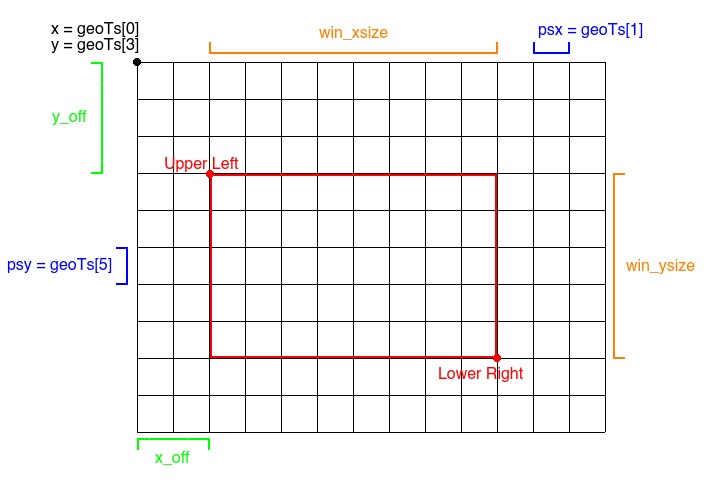
 
2. A partir del código anterior, defina una función que genere un recorte a partir de unas coordenadas y una imagen suministrada. La función deberá tener la siguiente estructura:

```python
ul_x, ul_y = 389015.794, 6527907.484
lr_x, lr_y = 391265.904, 6525657.498

ds = gdal.Open('../data/raw_data/SPOT_20170806_PAN.tif')


def subset_img(ds, ulx, uly, lrx, lry):
    '''
    Descripción de la función
    '''

    # código....

    return subset

subset = subset_img(ds, ul_x, ul_y, lr_x, lr_y)
 
```


Otras de las opciones interesantes son _buf_xsize_ y _buf_ysize_ que nos permite remuestrear nuestra imagen de entrada a una matriz de dimensiones dadas por dichos parámetros:
```python
sds2 = ds.GetRasterBand(1).ReadAsArray(buf_xsize=ds.RasterXSize//3,
                                       buf_ysize=ds.RasterYSize//3,
                                       resample_alg=0)

print(sds[:6, :6])
print(sds2[:2, :2])
```

Más sobre métodos de remuestreo consultar:
```python
from osgeo import gdalconst
help(gdalconst)
```

Veamos ahora el resultado de nuestras imágenes cargadas:

```python
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].imshow(sds, cmap='Greys_r')
ax[0].set_title('Original')
ax[1].imshow(sds2, cmap='Greys_r')
ax[1].set_title('Remuestreada')
plt.show()
```

También es posible obtener el tipo de dato _GDAL_ a partir de los valores contenidos en nuestro ***array*** como se muestra a continuación:

```python
from osgeo import gdal_array

print(colored('Tipo de dato del array:', 'blue'), sds.dtype, '\n')

print(colored('Código del tipo de de gdal:', 'blue'), gdal.GDT_UInt16, '\n')

gdalDType = gdal_array.NumericTypeCodeToGDALTypeCode(sds.dtype)

print(colored('Tipo de dato convertido a código gdal:', 'blue'), gdalDType)
```

# 3. Opciones de visualización

La visualización es un aspecto fundamental cuando queremos controlar de manera gráfica los resultados obtenidos (por ejemplo, valores más altos de un índice de vegetación en zonas boscosas que en el agua, visualización de clases obtenidas mediante clasificaciones, etc.). 

Anteriormente hemos visto la forma más básica de visualizar una imagen:

```python
ds = gdal.Open('../data/raw_data/SPOT_20170806_PAN.tif')
band_pan = ds.GetRasterBand(1)
sds_pan = band_pan.ReadAsArray(1000, 1000, 1500, 1500)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(sds_pan, cmap='Greys_r')
plt.show()
```

Podríamos incluso estimar el el _bounding box_ a partir de las geotransformaciones y adicionar los valores de coordenadas:

```python
# Calculamos los valores de coordenadas de los extremos
geoTs = ds.GetGeoTransform()
ulx = geoTs[0] + 1000 * geoTs[1]
uly = geoTs[3] + 1000 * geoTs[5]
lrx = ulx + 1500 * geoTs[1]
lry = uly + 1500 * geoTs[5]

# Si queremos guardar nuestro extent en alguna variable para
# utilizarlo más adelante:
mi_extent = [ulx, lrx, lry, uly]

# Graficamos haciendo uso del parámetro "extent"
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(sds_pan, cmap='Greys_r', extent=mi_extent)
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()
```

Esa figura es un poco básica y muy oscura, por lo tanto, vamos a aplicar algunos mecanismos de realce. Veamos la distribución de sus datos:

```python
plt.hist(sds_pan.ravel(), 50, facecolor='g', alpha=0.75)
plt.show()
```

Como vemos, la mayoría de sus datos se encuentran aproximadamente entre 200 y 1500. Podríamos probar definir estos umbrales de visualización u obtenerlos por otros métodos como por ejemplo:

```python
# Calculando valores máximo y mínimo de la banda:
vmin_band = np.nanmin(sds_pan)
vmax_band = np.nanmax(sds_pan)

print(colored('Valor mínimo de la banda:', 'blue'), vmin_band, '\n')
print(colored('Valor máximo de la banda:', 'blue'), vmax_band, '\n')

# Definiendo umbrales personalizados:
vmin_user = 200
vmax_user = 1500

print(colored('Valor mínimo personalizado:', 'blue'), vmin_user, '\n')
print(colored('Valor máximo personalizado:', 'blue'), vmax_user, '\n')

# Calculando percentiles:
p1 = 1  # Definirá el umbral mínimo en %
p2 = 99  # Definirá el umbral máximo en %
vmin_perc, vmax_perc = np.percentile(sds_pan, (p1, p2))

print(colored('Valor mínimo estimado por percentiles:', 'blue'),
      vmin_perc, '\n')
print(colored('Valor máximo estimado por percentiles:', 'blue'),
      vmax_perc, '\n')

# Calculando los umbrales como media ± desvío estándar
std = np.std(sds_pan)
vmean = np.nanmean(sds_pan)
num_dev = 2
vmin_std = vmean - num_dev*std
vmax_std = vmean + num_dev*std

print(colored('Valor mínimo estimado por número de desvíos estándar:', 'blue'),
      vmin_std, '\n')
print(colored('Valor máximo estimado por número de desvíos estándar:', 'blue'),
      vmax_std, '\n')
```

Graficando tendríamos:

```python
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

ax[0, 0].hist(sds_pan.ravel(), 50, facecolor='g', alpha=0.75)
ax[0, 0].axvline(x=vmax_user, color='y', linestyle=':', linewidth=3)
ax[0, 0].axvline(x=vmin_user, color='y', linestyle=':', linewidth=3,
                 label='Umbral personalizado')

ax[0, 1].hist(sds_pan.ravel(), 50, facecolor='g', alpha=0.75)
ax[0, 1].axvline(x=vmax_band, color='y', linestyle=':', linewidth=3)
ax[0, 1].axvline(x=vmin_band, color='y', linestyle=':', linewidth=3,
                 label='Umbral valores mínimo y máximo')

ax[1, 0].hist(sds_pan.ravel(), 50, facecolor='g', alpha=0.75)
ax[1, 0].axvline(x=vmax_perc, color='y', linestyle=':', linewidth=3)
ax[1, 0].axvline(x=vmin_perc, color='y', linestyle=':', linewidth=3,
                 label='Umbral percentil 1-99')

ax[1, 1].hist(sds_pan.ravel(), 50, facecolor='g', alpha=0.75)
ax[1, 1].axvline(x=vmax_std, color='y', linestyle=':', linewidth=3)
ax[1, 1].axvline(x=vmin_std, color='y', linestyle=':', linewidth=3,
                 label='Umbral desvío estándar')

ax[0, 0].legend(loc=1)
ax[0, 1].legend(loc=1)
ax[1, 0].legend(loc=1)
ax[1, 1].legend(loc=1)

plt.show()
```

Veamos el resultado al aplicar cada uno de los realces:

```python
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

im1 = ax[0, 0].imshow(sds_pan, cmap='gray')
im2 = ax[0, 1].imshow(sds_pan, vmin=vmin_user, vmax=vmax_user, cmap='gray')
im3 = ax[1, 0].imshow(sds_pan, vmin=vmin_perc, vmax=vmax_perc, cmap='gray')
im4 = ax[1, 1].imshow(sds_pan, vmin=vmin_std, vmax=vmax_std, cmap='gray')

plt.colorbar(im1, ax=ax[0, 0])
plt.colorbar(im2, ax=ax[0, 1])
plt.colorbar(im3, ax=ax[1, 0])
plt.colorbar(im4, ax=ax[1, 1])

fig.suptitle('Umbrales utilizados')
ax[0, 0].set_title('Original min - max')
ax[0, 1].set_title('Personalizado')
ax[1, 0].set_title('Definido por Percentiles')
ax[1, 1].set_title('Definido por número de desvíos estándar')

ax[0, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[1, 0].set_axis_off()
ax[1, 1].set_axis_off()

fig.tight_layout()
plt.show()
```

### Ejercicio 3.1:

Crear una función llamada `scale(array, p)` a la que le pasemos un array en 2D y un valor opcional de percentil p . La idea es que la función escale el mismo a valores entre 0 y 1, tomando como mínimo el percentil p y como valor máximo a 100-p. El valor por defecto de p debe ser 0 La estructura deberá ser algo como:

```python
def scale(array, p=0):
    '''
    Descripción de la función
    '''
    vmin = ...
    vmax = ...

    scaled = ...

    return scaled
```

*Atención: Si usás p > 0, prestá atención a los valores por debajo y por encima de p ¿Qué cuidado especial debés tener con ellos para que todo quede escalado entre 0 y 1?*



# 4. Cargando imágenes desde un zip:

Anteriormente vimos como hacer un listado de imágenes desde un archivo comprimido utilizando la librería "zipfile". Ahora vamos a ver un breve ejemplo de como cargarlas, para esto, vamos a reutilizar el código visto anteriormente pero nos quedaremos únicamente con la banda 2 de nuestra imagen Sentinel.

```python
from zipfile import ZipFile  # Importamos el módulo ZipFile

data_dir = '../data/raw_data/'
fn_zip = 'L1C_T21HUB_A017181_20181006T135109.zip'
zipfilename = data_dir + fn_zip

# El siguiente bloque realiza un listado recursivo
# de los archivos contenidos en nuestro .zip
with ZipFile(zipfilename, 'r') as zfile:
    banda = [i for i in zfile.namelist() if i.endswith('B02.jp2')][0]

banda
```

Una vez tenemos nuestra banda, vamos a cargarla con "gdal", para lo que necesitaremos construir nuestra ruta de la siguiente manera:

```python
archivo = '/vsizip/' + 'ruta_nombre_archivo.zip' + '/' + 'ruta_nombre_imagen'
```

Entonces tenemos que:
```python
imagen = f'/vsizip/{zipfilename}/{banda}'
```

Ahora si vamos a cargar nuestra banda y, aplicando lo visto un poco más arriba, vamos a graficar un subset de la misma aplicando ajustando nuestro rango de datos a los percentiles 1, 99:

```python
# Cargamos nuestra banda con gdal
ds = gdal.Open(imagen)

# Leemos un subset de nuestra imagen
sds = ds.GetRasterBand(1).ReadAsArray(1000, 1000, 1500, 1500)

# Calculamos los valores mínimos y máximos para ajustar la visualización
vmin, vmax = np.percentile(sds, (1, 99))

# Graficamos nuestra imagen en escala de grises
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(sds, cmap='gray', vmin=vmin, vmax=vmax)
plt.show()
```

# 5. Formato HDF

Es un formato ampliamente utilizado en el campo de la teledetección. Soporta varios tipos de datos como arrays, tablas o textos, siendo muy útil por ejemplo para el manejo de los metadatos, dado que estos se almacenan en el mismo archivo. Veamos esto con un ejemplo:

```python
# Importamos las librerías
from osgeo import gdal

# Definamos la imagen a utilizar:
img = '../data/raw_data/MOD09A1.A2000049.h11v08.006.2015136143404.hdf'
```

_gdal_ cuenta con una herramienta que nos permite rápidamente consultar los metadatos de las imágenes que queremos utilizar. Esta puede ser llamada desde consola haciendo uso del comando:
```
gdalinfo nombre_de_imagen
```
Adicionalmente, podemos hacer llamados a comandos de consola anteponiento el signo _!_, de la manera:
```
!gdalinfo nombre_de_imagen
```
Probemos:
```python
!gdalinfo ../data/raw_data/MOD09A1.A2000049.h11v08.006.2015136143404.hdf
```

Para consultar acerca de los productos MODIS, vaya al siguiente [enlace](https://lpdaac.usgs.gov/product_search/?collections=Combined+MODIS&collections=Terra+MODIS&collections=Aqua+MODIS&view=list)

Una vez tenemos el nombre de nuestro _dataset_, podríamos abrirlo como una imagen

```python
ds = gdal.Open('HDF4_EOS:EOS_GRID:"../data/raw_data/MOD09A1.A2000049.h11v08.006.2015136143404.hdf":MOD_Grid_500m_Surface_Reflectance:sur_refl_b01')
sds = ds.GetRasterBand(1).ReadAsArray()
```

Prueben consultar la información de esta imagen de la misma manera que hicimos con el _geotiff_.

Graficando nuestra imagen tenemos:

```python
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(sds)
plt.show()
```

Una manera de obtener información directamente desde python y que facilite la automatización, es cargando el archivo completo y consultando el nombre de los _subdatasets_:

```python
image = gdal.Open(img)
subdatasets = image.GetSubDatasets()
del image
print(subdatasets)
```

Como vemos, la información se encuentra almacenada en un listado de tuplas, donde cada tupla corresponde a un par (_nombre_imagen_, _descripcion_), por lo que podríamos hacer uso de lo visto con la librería _Pandas_ para ver nuestra información de una manera más clara:

```python
import pandas as pd
pd.options.display.max_colwidth = 77
df = pd.DataFrame(subdatasets, columns=['image', 'description'])
df
```

Con la información de las imágenes disponibles podríamos por ejemplo automatizar la búsqueda y carga de las bandas de interés. Vamos a cargar por ejemplo la banda 1 a partir de lo que se muestra en el _dataframe_.

```python
# Busquemos la información de nuestra banda de interés:
b01 = df.loc[df['description'].str.contains('b01'), 'image']  # Datos de acceso
b01[0]
```

Vamos a cargar nuestra imagen y a obtener la información de metadatos:
```python
ds = gdal.Open(b01[0])
ds.GetMetadata()
```

Consultemos nuestro valor _nodata_:

```python
ds_band = ds.GetRasterBand(1)
print(colored('Valor para datos no válidos:', 'blue'))
print(ds_band.GetNoDataValue())
print(colored('Factor de escala:', 'blue'))
print(ds_band.GetScale())
```

Carguemos nuestro array:

```python
sds = ds_band.ReadAsArray()
```

Grafiquemos nuestro array:

```python
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(sds)
plt.show()
```

Podríamos construir a partir del nombre de entrada y la descripción, un nombre de salida representativo para nuestra banda. En este caso, vamos a formar algo como:

../data/out/MOD09A1.A2000049.h11v08.006.2015136143404_sur_refl_b01.tif

```python
import os

# Descripción de la banda:
b01_desc = df.loc[df['description'].str.contains('b01'), 'description']
print(colored('Descripción de la banda b01:\n', 'blue'), b01_desc[0])

input_basename = os.path.basename(img)
print(colored('Nombre base del archivo hdf:\n', 'blue'), input_basename)

# Vamos a agregarle parte de la descripción
band_desc = b01_desc[0].split(' ')[1]
print(colored('Texto que vamos a agregar:\n', 'blue'), band_desc)

output_path = '../data/out/'  # Directorio de salida
output_name = output_path + input_basename[:-4] + '_' + band_desc + '.tif'
print(colored('Nombre de archivo de salida:\n', 'blue'), output_name)
```

Profundizaremos en el guardado de las imágenes en la siguiente clase, extendiendo el concepto a ráster multibanda. Por ahora, un adelanto es extraer la información que necesitaremos:

- Nombre de salida (generado previamente)
- Número de bandas
- Número de filas y columnas
- GeoTransformaciones
- SRC
- Formato
- Tipo de dato

```python
bands = ds.RasterCount
cols = ds.RasterXSize
rows = ds.RasterYSize
geoTs = ds.GetGeoTransform()
prj = ds.GetProjection()
drv = gdal.GetDriverByName('GTiff')
gdalDType = gdal_array.NumericTypeCodeToGDALTypeCode(sds.dtype)
nodata = ds_band.GetNoDataValue()
scale_factor = float(dict(ds.GetMetadata())['scale_factor'])

print(colored('Nombre de archivo de salida:', 'blue'), output_name)
print(colored('Número de bandas:', 'blue'), bands)
print(colored('Geotransformaciones:', 'blue'), geoTs)
print(colored('SRC:', 'blue'), prj)
print(colored('Formato:', 'blue'), drv.LongName)
print(colored('Tipo de dato:', 'blue'), gdalDType)
# print(gdal.GDT_Int16)
print(colored('Columnas:', 'blue'), cols)
print(colored('Filas:', 'blue'), rows)
print(colored('Valor sin datos:', 'blue'), nodata)
print(colored('Factor de escala:', 'blue'), scale_factor)
```

# 5. Formato NetCDF

NetCDF es un formato ampliamente utilizado en meteorologia y otras ciencias de la tierra. Al igual que el HDF posee una estructura interna que permite almacenar tanto los datos como sus metadatos. Una de las librerías que permite trabajar con este formato es _xarray_, que usaremos para visualizar imágenes del satélite meteorológico [GOES](https://www.goes-r.gov/).

Esta librería está diseñada para trabajar con datos multidimensionales etiquetados, similar a [NumPy](https://numpy.org/) pero con etiquetas y metadatos. Para ver esto, vamos a leer las imágenes GOES desde la subcarpeta del mismo nombre, localizada en _data/raw_data_:

```python
import os
#Generar la lista de archivos con listdir
input_folder = '../data/raw_data/GOES'
goes_files = os.listdir(input_folder)

print(goes_files)
```

Leemos el primer archivo de la carpeta (elemento 0 de la lista) y lo abrimos con _xarray_ usando el método _open_dataset()_. Si imprimimos su contenido Jupyter Notebook nos permite navegar por la estructura del archivo de manera interactiva, y podemos ver cuáles son las variables o atributos para los cuales tiene información este archivo:

``` python
# Seleccionar el primer archivo de la lista
selected_file = goes_files[0]
selected_path = os.path.join(input_folder,selected_file)
print(selected_path)

# Importar el archivo con NetCDF
import xarray as xr
ds = xr.open_dataset(selected_path)
# Visualización de la estructura
ds
```

A continuación nos quedamos con la variable Temperatura de superficie (LST) y la ploteamos. En lugar de usar simplemente _imshow()_, llamamos al método _plot()_ que es propio de los objetos _xarray_, el cual hace que la salida sea más fácilmente interpretable:

``` python
# Nos quedamos con la variable LST (Temperatura de Superficie)
variable_data = ds['LST']

# Ploteo
plt.figure(figsize=(6, 6))
variable_data.plot(cmap = "viridis")
# Show plot
plt.show()
```